In [ ]:
pip install numpy pandas matplotlib seaborn scikit-learn opencv-python tensorflow torch torchvision albumentations

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/dataset" /content/


In [ ]:
import os
print(os.listdir("/content/dataset"))


['Second Print', 'First Print']


In [ ]:
import os

data_path = "/content/dataset"  # Replace with actual dataset folder name
first_print_path = os.path.join(data_path, "First Print")
second_print_path = os.path.join(data_path, "Second Print")

num_first_print = len(os.listdir(first_print_path))
num_second_print = len(os.listdir(second_print_path))

print(f"Number of first print (original) images: {num_first_print}")
print(f"Number of second print (counterfeit) images: {num_second_print}")



Number of first print (original) images: 100
Number of second print (counterfeit) images: 100


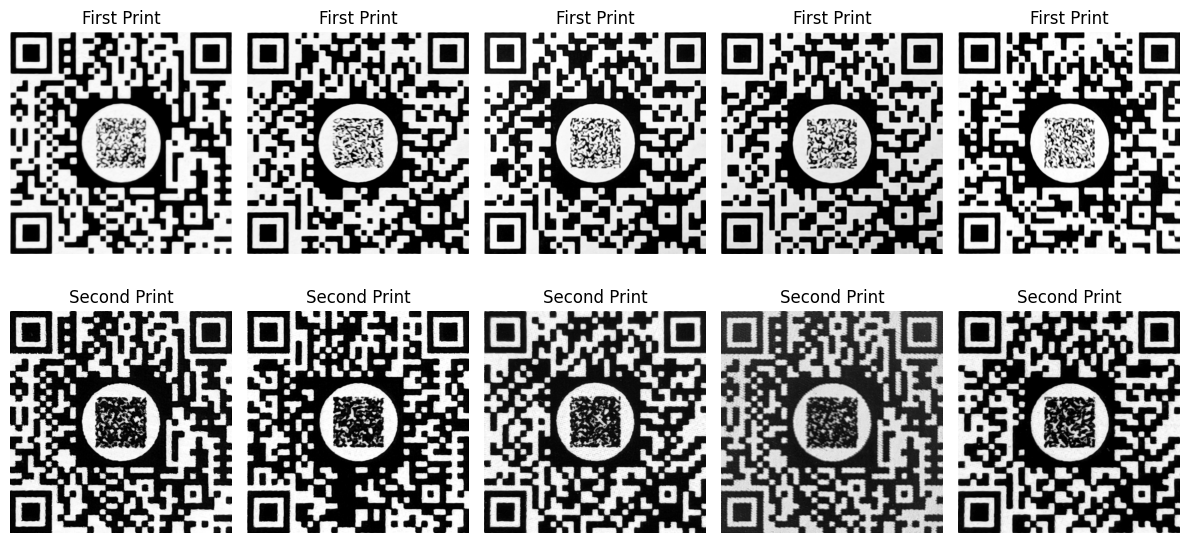

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    original_images = random.sample(os.listdir(first_print_path), 5)
    counterfeit_images = random.sample(os.listdir(second_print_path), 5)

    for i, img_name in enumerate(original_images):
        img = cv2.imread(os.path.join(first_print_path, img_name), cv2.IMREAD_GRAYSCALE)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("First Print")
        axes[0, i].axis('off')

    for i, img_name in enumerate(counterfeit_images):
        img = cv2.imread(os.path.join(second_print_path, img_name), cv2.IMREAD_GRAYSCALE)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title("Second Print")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images()

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image

dataset_path = Path("/content/dataset")
class_stats = {}

for cls in ["First Print", "Second Print"]:
    images = list((dataset_path / cls).glob("*.png"))  # or .jpg
    stats = {'count': len(images), 'mean_brightness': [], 'contrast': []}

    for img_path in images:
        img = Image.open(img_path).convert("L")
        img_np = np.array(img) / 255.0
        stats['mean_brightness'].append(np.mean(img_np))
        stats['contrast'].append(np.std(img_np))

    stats['mean_brightness'] = np.mean(stats['mean_brightness'])
    stats['contrast'] = np.mean(stats['contrast'])
    class_stats[cls] = stats

print(class_stats)

{'First Print': {'count': 100, 'mean_brightness': np.float64(0.47692074048760646), 'contrast': np.float64(0.39644233770338205)}, 'Second Print': {'count': 100, 'mean_brightness': np.float64(0.4124018550407756), 'contrast': np.float64(0.3813449286199345)}}


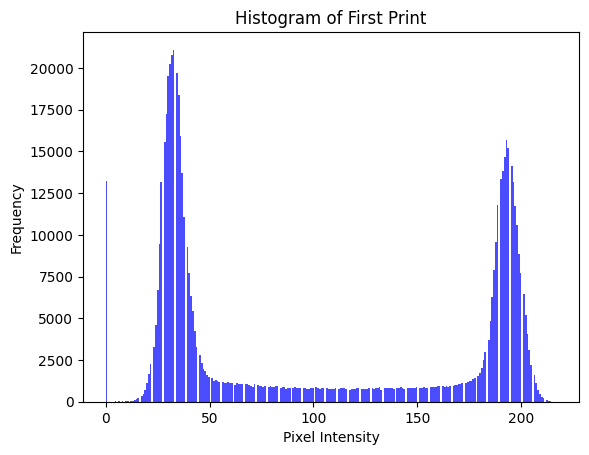

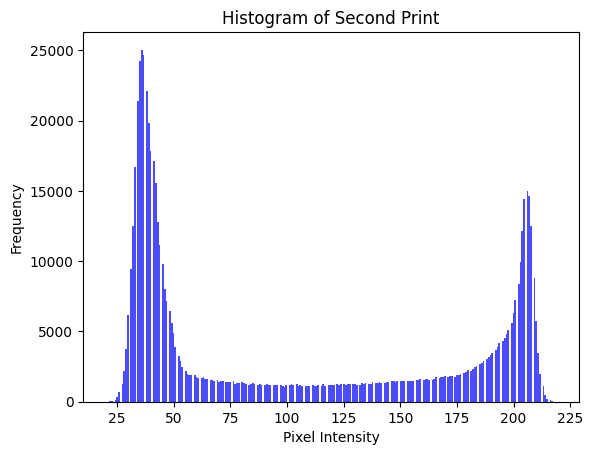

In [ ]:
def plot_histogram(image_path, title):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.hist(img.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Pick one random original and counterfeit image
original_sample = os.path.join(first_print_path, os.listdir(first_print_path)[0])
counterfeit_sample = os.path.join(second_print_path, os.listdir(second_print_path)[0])

plot_histogram(original_sample, "Histogram of First Print")
plot_histogram(counterfeit_sample, "Histogram of Second Print")



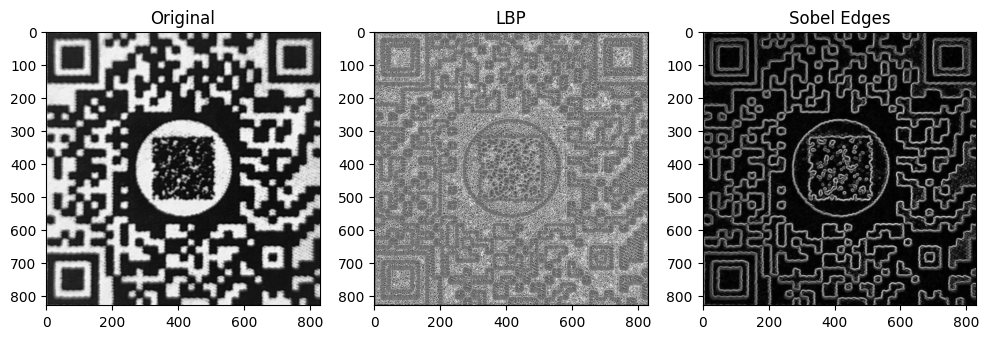

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.filters import sobel

img = np.array(Image.open(images[0]).convert("L"))
lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
edges = sobel(img)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(lbp, cmap='gray'); plt.title("LBP")
plt.subplot(1, 3, 3); plt.imshow(edges, cmap='gray'); plt.title("Sobel Edges")
plt.show()


In [ ]:
from skimage.feature import local_binary_pattern
from skimage.filters import sobel
from skimage import exposure

def extract_features(img_path):
    img = Image.open(img_path).convert("L").resize((224, 224))
    img_np = np.array(img) / 255.0

    lbp = local_binary_pattern(img_np, P=8, R=1, method='uniform')
    edge_img = sobel(img_np)

    features = [
        np.mean(img_np),  # brightness
        np.std(img_np),   # contrast
        np.mean(lbp),     # LBP mean
        np.std(lbp),      # LBP contrast
        np.mean(edge_img), # Edge density
    ]
    return features


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X, y = [], []
for cls_label, cls in enumerate(["First Print", "Second Print"]):
    for img_path in (dataset_path / cls).glob("*.png"):
        X.append(extract_features(img_path))
        y.append(cls_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["First Print", "Second Print"]))


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


              precision    recall  f1-score   support

 First Print       0.50      0.10      0.16        21
Second Print       0.47      0.89      0.62        19

    accuracy                           0.47        40
   macro avg       0.49      0.49      0.39        40
weighted avg       0.49      0.47      0.38        40



In [ ]:
import numpy as np
import cv2
from skimage.measure import shannon_entropy

def compute_image_stats(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    entropy_value = shannon_entropy(img)

    return mean_intensity, std_intensity, entropy_value

# Compute stats for first and second prints
original_stats = compute_image_stats(original_sample)
counterfeit_stats = compute_image_stats(counterfeit_sample)

print(f"First Print - Mean: {original_stats[0]:.2f}, Std: {original_stats[1]:.2f}, Entropy: {original_stats[2]:.2f}")
print(f"Second Print - Mean: {counterfeit_stats[0]:.2f}, Std: {counterfeit_stats[1]:.2f}, Entropy: {counterfeit_stats[2]:.2f}")



First Print - Mean: 102.56, Std: 74.65, Entropy: 6.53
Second Print - Mean: 104.34, Std: 70.91, Entropy: 6.75


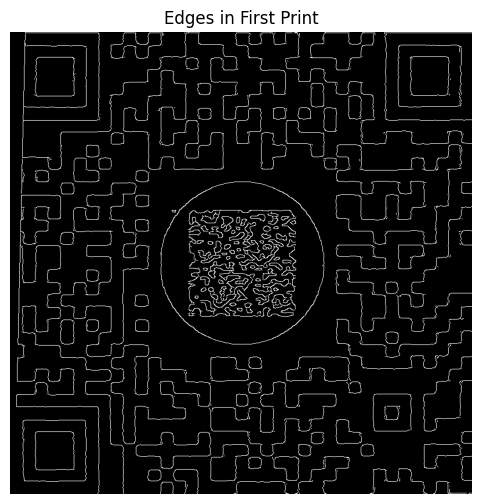

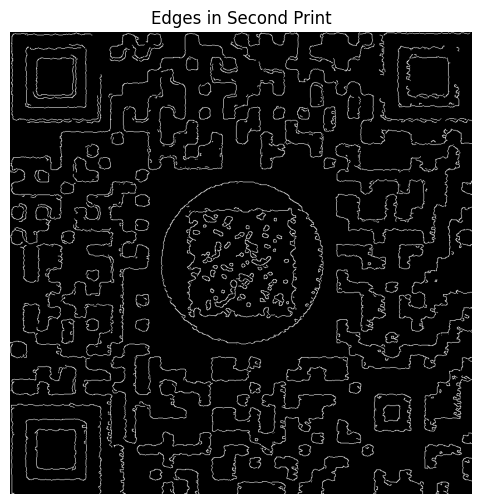

In [ ]:
import cv2
import matplotlib.pyplot as plt

def edge_detection(image_path, title):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)  # Canny edge detection

    plt.figure(figsize=(6,6))
    plt.imshow(edges, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

edge_detection(original_sample, "Edges in First Print")
edge_detection(counterfeit_sample, "Edges in Second Print")


In [ ]:
import cv2
import numpy as np

def compute_edge_density(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)  # Canny edge detection
    edge_density = np.sum(edges > 0) / edges.size  # Compute edge density
    return edge_density

# Compute edge densities
edge_density_original = compute_edge_density(original_sample)
edge_density_counterfeit = compute_edge_density(counterfeit_sample)

print(f"Edge Density - First Print: {edge_density_original:.4f}")
print(f"Edge Density - Second Print: {edge_density_counterfeit:.4f}")


Edge Density - First Print: 0.0487
Edge Density - Second Print: 0.0520


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

# Function to compute GLCM texture features
def compute_glcm_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Compute GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extract texture features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return contrast, correlation, energy, homogeneity

first_contrast, first_correlation, first_energy, first_homogeneity = compute_glcm_features(original_sample)
second_contrast, second_correlation, second_energy, second_homogeneity = compute_glcm_features(counterfeit_sample)

# Display results
print(f"First Print - Contrast: {first_contrast:.4f}, Correlation: {first_correlation:.4f}, Energy: {first_energy:.4f}, Homogeneity: {first_homogeneity:.4f}")
print(f"Second Print - Contrast: {second_contrast:.4f}, Correlation: {second_correlation:.4f}, Energy: {second_energy:.4f}, Homogeneity: {second_homogeneity:.4f}")


First Print - Contrast: 95.9941, Correlation: 0.9914, Energy: 0.0572, Homogeneity: 0.4259
Second Print - Contrast: 63.2905, Correlation: 0.9937, Energy: 0.0545, Homogeneity: 0.3984


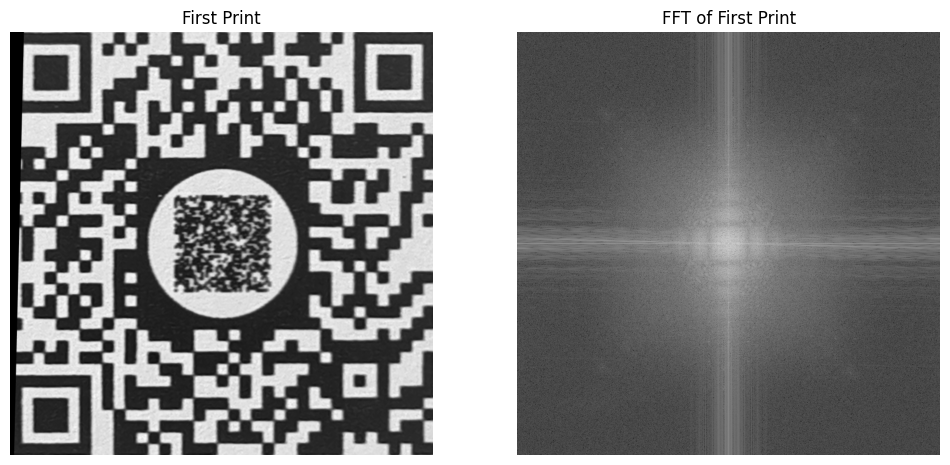

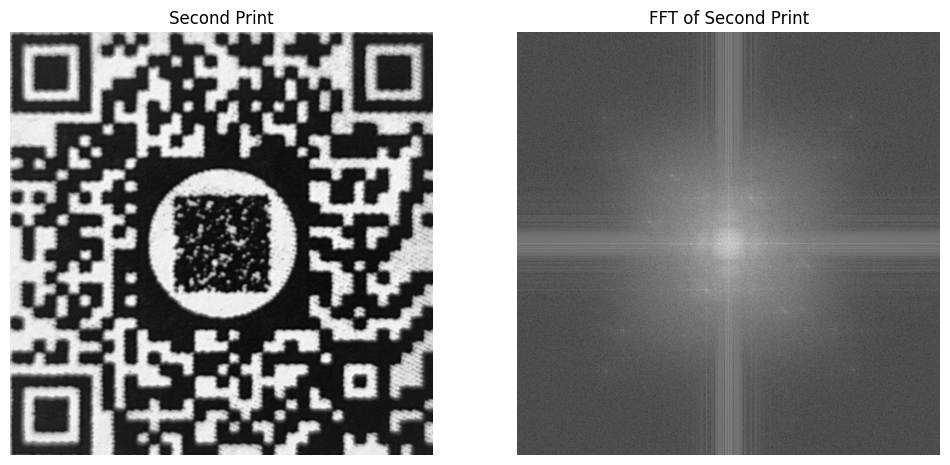

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_fft(image_path, title):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    f = np.fft.fft2(img)  # Compute 2D FFT
    fshift = np.fft.fftshift(f)  # Shift the zero-frequency component to the center
    magnitude_spectrum = 20 * np.log(np.abs(fshift))  # Compute magnitude spectrum

    # Plot original image and FFT magnitude spectrum
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f"FFT of {title}")
    plt.axis("off")

    plt.show()

# Apply FFT to one original and one counterfeit image
compute_fft(original_sample, "First Print")
compute_fft(counterfeit_sample, "Second Print")


In [ ]:
def extract_fft_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)

    # Compute mean and standard deviation of frequency components
    mean_freq = np.mean(magnitude_spectrum)
    std_freq = np.std(magnitude_spectrum)

    return mean_freq, std_freq

# Compute FFT features for both classes
first_mean_freq, first_std_freq = extract_fft_features(original_sample)
second_mean_freq, second_std_freq = extract_fft_features(counterfeit_sample)

print(f"First Print - Mean FFT Magnitude: {first_mean_freq:.2f}, Std Dev: {first_std_freq:.2f}")
print(f"Second Print - Mean FFT Magnitude: {second_mean_freq:.2f}, Std Dev: {second_std_freq:.2f}")


First Print - Mean FFT Magnitude: 7662.32, Std Dev: 100812.30
Second Print - Mean FFT Magnitude: 6744.48, Std Dev: 104490.22


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from skimage import io, color

def extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None  # Handle invalid images

    # Image statistics
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    image_entropy = entropy(image.ravel())

    # Edge Density
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])

    # GLCM Texture Features
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # FFT Features
    f_transform = np.fft.fft2(image)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    fft_mean = np.mean(magnitude_spectrum)
    fft_std = np.std(magnitude_spectrum)

    return [image_path, mean_intensity, std_intensity, image_entropy, edge_density,
            contrast, correlation, energy, homogeneity, fft_mean, fft_std]

# Process all images
image_folder = "/content/drive/MyDrive/dataset"
  # Change to your dataset folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

data = []
for img in image_files:
    img_path = os.path.join(image_folder, img)
    features = extract_features(img_path)
    if features:
        data.append(features)

# Create DataFrame
columns = ["image_path", "mean_intensity", "std_intensity", "entropy", "edge_density",
           "contrast", "correlation", "energy", "homogeneity", "fft_mean", "fft_std"]
df = pd.DataFrame(data, columns=columns)

# Save dataset
df.to_csv("image_features.csv", index=False)
print("Feature extraction complete. Dataset saved as image_features.csv")

Feature extraction complete. Dataset saved as image_features.csv
